## Human blood derived macropahge QC and analysis
## Fan Zhang
## 2020-04-15

In [1]:
suppressMessages({
                  library(data.table)
                  library(reticulate)
                  library(Rcpp)
                  library(scales)
                  library(irlba)
                  library(singlecellmethods)
                  library(parallel)
                  library(pbapply)
                  library(patchwork)
                  library(pheatmap)
                  library(entropy)
                  library(Rtsne)
                  library(loe)
                  library(igraph)
                  library(viridis)
                  library(magrittr)
                  library(gridExtra)
                  library(ggthemes)
                  library(cowplot)
                  library(reticulate)
                  library(ggbeeswarm)
                  library(ggrepel)
                  library(ggplot2)
                  library(gridExtra)
                  library(ggthemes)
                  library(dplyr)
                  library(RColorBrewer)
                  library(ggbeeswarm)
                  library(ggrepel)
                  library(MASS)
                  library(matrixStats)
                  library(viridis)
                  library(grid)
                  require(gdata)
                  library(Seurat)
                  library(harmony)
                  library(matrixStats)
                  library(plyr)
                  library(RcppArmadillo)
})



meta_colors <- list(

  stim = c(
         "IFNb"    = "#CC8899",
         "TNFa"         = "#8DD3C7",
         "TNFa with fibro" = "#FFFFB3", 
         "IFNr"        =  "#807DBA",
         "IFNr with fibro"= "#FB8072",
         "TNFa and IFNr"  = "#80B1D3",
         "TNFa and IFNr with fibro+" = "#FDB462",
         "Control"        = "#999999",
         "IL4"         = "#FCCDE5",
         "IFNg"        =  "#807DBA",
         "IFNg with fibro"= "#FB8072",
         "TNFa and IFNg"  = "#80B1D3",
         "TNFa and IFNg with fibro" = "#FDB462",
         "Untreated"        = "#B3DE69"
  ),
    
  cluster = c(
          "0" = "#80B1D3",
          "1" = "#FB8072",
          "2" = "#999999",
          "3" = "#FFFFB3",
          "4" = "#8DD3C7", 
          "5" = "#CC8899",
          "6" = "#74C476",
          "7" = "#FDB462",

          "IFNg" = "#807DBA",
          "IFNg with fibro" = "#FB8072",
          "TNFa and IFNg" = "#80B1D3",
          "IFNg / IFNg with fibro" = "#FB8072",
          "Untreated" = "#999999",
          "TNFa with fibro" = "#FFFFB3",
          "IL4" = "#FCCDE5", 
          "IFNb" = "#CC8899",
          "TNFa" = "#8DD3C7", 
          "TNFa and IFNg with fibro" = "#FDB462"
  ),
    
  sample = c(
            "sample_1" =  "#E41A1C",
            "sample_2" = "#377EB8",
            "sample_3" = "#4DAF4A",
            "sample_4" = "#984EA3" 
  )

)


Warning message:
“package ‘patchwork’ was built under R version 3.6.3”Warning message:
“package ‘Rtsne’ was built under R version 3.6.3”Warning message:
“package ‘cowplot’ was built under R version 3.6.3”Warning message:
“package ‘ggrepel’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”

In [3]:
# Functions
FindVariableGenesBatch <- function(exprs_mat, meta_df, genes_exclude = NULL, ngenes_use = 1e3, expr_min = .1) {
    if (!is.null(genes_exclude)) {
        genes_use <- setdiff(row.names(exprs_mat), genes_exclude)
    }
    x_res <- split(meta_df$cell, meta_df$sample) %>% lapply(function(x) {
        FindVariableGenesSeurat(exprs_mat[genes_use, x]) %>% 
            subset(gene.mean >= expr_min) %>% 
            tibble::rownames_to_column("gene") %>% 
            dplyr::arrange(-gene.dispersion) %>%
            head(ngenes_use)
    })
    data.table(Reduce(rbind, x_res))[, .N, by = gene][order(-N)]    
}



FindVariableGenesSeurat <- function (data, x.low.cutoff = 0.1, x.high.cutoff = 8,
                                     y.cutoff = 1, y.high.cutoff = Inf, num.bin = 0,
                                     binning.method = "equal_width", sort.results = TRUE,
                                     display.progress = TRUE, ...)
{
    genes.use <- rownames(data)
    if (class(data) != "dgCMatrix") {
        data <- as(as.matrix(data), "dgCMatrix")
    }
    ## (1) get means and variances
    gene.mean <- FastExpMean(data, display.progress)
    names(gene.mean) <- genes.use
    gene.dispersion <- FastLogVMR(data, display.progress)
    names(gene.dispersion) <- genes.use

    gene.dispersion[is.na(x = gene.dispersion)] <- 0
    gene.mean[is.na(x = gene.mean)] <- 0

    mv.df <- data.frame(gene.mean, gene.dispersion)
    rownames(mv.df) <- rownames(data)

    ## (OPTIONAL) do the binning correction
    if (num.bin > 0) {
      if (binning.method == "equal_width") {
          data_x_bin <- cut(x = gene.mean, breaks = num.bin)
      }
      else if (binning.method == "equal_frequency") {
          data_x_bin <- cut(x = gene.mean, breaks = c(-1, quantile(gene.mean[gene.mean >
              0], probs = seq(0, 1, length.out = num.bin))))
     }
      else {
          stop(paste0("Invalid selection: '", binning.method,
              "' for 'binning.method'."))
      }
      names(x = data_x_bin) <- names(x = gene.mean)
      mean_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = mean)
      sd_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = sd)
      gene.dispersion.scaled <- (gene.dispersion - mean_y[as.numeric(x = data_x_bin)])/sd_y[as.numeric(x = data_x_bin)]
      gene.dispersion.scaled[is.na(x = gene.dispersion.scaled)] <- 0
      ##names(gene.dispersion.scaled) <- names(gene.mean)

      mv.df$gene.dispersion.scaled <- gene.dispersion.scaled
    }

    return(mv.df)
}

environment(FindVariableGenesSeurat) <- asNamespace("Seurat")

ScaleDataSeurat <- function (data.use, margin = 1, scale.max = 10,
                                block.size = 1000) {

    if (margin == 2) data.use %<>% t
    max.block <- ceiling(nrow(data.use)/block.size)

    ## Define data and functions to use in sparse and dense cases
    if (class(data.use) == "dgCMatrix" | class(data.use) == "dgTMatrix") {
        scale_fxn <- function(x) {
            FastSparseRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
        }
    } else {
        scale_fxn <- function(x) {
            FastRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
       }
        data.use <- as.matrix(data.use)
    }

    ## Do scaling, at once or in chunks
    if (max.block == 1) {
        scaled.data <- scale_fxn(data.use)
    } else {
        scaled.data <- matrix(NA, nrow(data.use), ncol(data.use))
        for (i in 1:max.block) {
            idx.min <- (block.size * (i - 1))
            idx.max <- min(nrow(data.use), (block.size * i - 1) + 1)
            my.inds <- idx.min:idx.max
            scaled.data[my.inds, ] <- scale_fxn(data.use[my.inds, , drop = F])
        }
    }

    colnames(scaled.data) <- colnames(data.use)
    row.names(scaled.data) <- row.names(data.use)
    scaled.data[is.na(scaled.data)] <- 0
    if (margin == 2) scaled.data %<>% t
    return(scaled.data)
}
environment(ScaleDataSeurat) <- asNamespace("Seurat")


fig.size <- function(height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

SingleFeaturePlotSeurat <- function (data.use, feature, data.plot, pt.size, pch.use, cols.use,
    dim.codes, min.cutoff, max.cutoff, coord.fixed, no.axes,
    no.title = FALSE, no.legend, dark.theme, vector.friendly = FALSE,
    png.file = NULL, png.arguments = c(10, 10, 100))
{
    if (vector.friendly) {
        previous_call <- blank_call <- png_call <- match.call()
        blank_call$pt.size <- -1
        blank_call$vector.friendly <- FALSE
        png_call$no.axes <- TRUE
        png_call$no.legend <- TRUE
        png_call$vector.friendly <- FALSE
        png_call$no.title <- TRUE
        blank_plot <- eval(blank_call, sys.frame(sys.parent()))
        png_plot <- eval(png_call, sys.frame(sys.parent()))
        png.file <- SetIfNull(x = png.file, default = paste0(tempfile(),
            ".png"))
        ggsave(filename = png.file, plot = png_plot, width = png.arguments[1],
            height = png.arguments[2], dpi = png.arguments[3])
        to_return <- AugmentPlot(blank_plot, png.file)
        file.remove(png.file)
        return(to_return)
    }
    idx.keep <- which(!is.na(data.use[feature, ]))
    data.gene <- data.frame(data.use[feature, idx.keep])
#     data.gene <- na.omit(object = data.frame(data.use[feature,
#         ]))
    min.cutoff <- SetQuantile(cutoff = min.cutoff, data = data.gene)
    max.cutoff <- SetQuantile(cutoff = max.cutoff, data = data.gene)
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    data_plot <- data.plot[idx.keep, ]
    data_plot$gene <- data.gene
    if (length(x = cols.use) == 1) {
        brewer.gran <- brewer.pal.info[cols.use, ]$maxcolors
    }
    else {
        brewer.gran <- length(x = cols.use)
    }
    if (all(data.gene == 0)) {
        data.cut <- 0
    }
    else {
        data.cut <- as.numeric(x = as.factor(x = cut(x = as.numeric(x = data.gene),
            breaks = brewer.gran)))
    }
    data_plot$col <- as.factor(x = data.cut)
    p <- data_plot %>%
        dplyr::arrange(col) %>%
        ggplot(mapping = aes(x = x, y = y))
    if (brewer.gran != 2) {
        if (length(x = cols.use) == 1) {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_brewer(palette = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
        else {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_manual(values = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
    }
    else {
        if (all(data_plot$gene == data_plot$gene[1])) {
            warning(paste0("All cells have the same value of ",
                feature, "."))
            p <- p + geom_point(color = cols.use[1], size = pt.size,
                shape = pch.use)
        }
        else {
            p <- p + geom_point(mapping = aes(color = gene),
                size = pt.size, shape = pch.use) + scale_color_viridis(option = "plasma", end = .9
    )
        }
    }
    if (dark.theme) {
        p <- p + DarkTheme()
    }
    if (no.axes) {
        p <- p + theme(axis.line = element_blank(), axis.text.x = element_blank(),
            axis.text.y = element_blank(), axis.ticks = element_blank(),
            axis.title.x = element_blank(), axis.title.y = element_blank())
        if (!no.title)
            p <- p + labs(title = feature, x = "", y = "")
        if (no.title)
            p <- p + labs(x = "", y = "")
    }
    else {
        if (no.title)
            p <- p + labs(x = dim.codes[1], y = dim.codes[2])
        if (!(no.title))
            p <- p + labs(title = feature) + labs(x = "", y = "")
    }
    if (no.legend) {
        p <- p + theme(legend.position = "none")
    }
    if (coord.fixed) {
        p <- p + coord_fixed()
    }
    return(p)
}
environment(SingleFeaturePlotSeurat) <- asNamespace("Seurat")

PlotFeatures <- function(umap_use, features_plot, exprs_use, cells_use, ncols, pt_size = .5, pt_shape = ".", q_lo = "q10", q_hi = "q90") {
    if (missing(cells_use)) cells_use <- 1:nrow(umap_use)
    if (missing(ncols)) ncols <- round(sqrt(length(features_plot)))
    
    plt_list <- lapply(features_plot, function(feature_use) {
        SingleFeaturePlotSeurat(exprs_use[, cells_use], feature_use, data.frame(x = umap_use[cells_use, 1], y = umap_use[cells_use, 2]),
                                pt.size = pt_size, pch.use = pt_shape, cols.use = c("lightgrey", "blue"),
                                dim.codes = c("UMAP 1", "UMAP 2"), min.cutoff = c(q10 = q_lo), max.cutoff = c(q90 = q_hi),
                                coord.fixed = FALSE, no.axes = FALSE, dark.theme = FALSE, no.legend = TRUE)
    })
    plot_grid(plotlist = plt_list, ncol = ncols)
    #return(plt_list)
}

BuildSNNSeurat <- function (data.use, k.param = 30, prune.SNN = 1/15, nn.eps = 0) {
    my.knn <- nn2(data = data.use, k = k.param, searchtype = "standard", eps = nn.eps)
    nn.ranked <- my.knn$nn.idx

    snn_res <- ComputeSNN(nn_ranked = nn.ranked, prune = prune.SNN)
    rownames(snn_res) <- row.names(data.use)
    colnames(snn_res) <- row.names(data.use)
    return(snn_res)
}
environment(BuildSNNSeurat) <- asNamespace("Seurat")

NormalizeDataSeurat <- function(A, scaling_factor = 1e4, do_ftt = FALSE) {
	A@x <- A@x / rep.int(Matrix::colSums(A), diff(A@p))
    A@x <- scaling_factor * A@x
    if (do_ftt) {
        A@x <- sqrt(A@x) + sqrt(1 + A@x)
    } else {
        A@x <- log(1 + A@x)
    }
	return(A)
}

In [ ]:
## Load the data

In [5]:
sample_1 <- Seurat::Read10X("/data/srlab/fzhang/amp/results/2020_04_06_human_derived_macrophage_HTO/data/200319_KW7966_10x_rawbcl/cellranger-3.1.0/GRCh38/BRI-783/outs/filtered_feature_bc_matrix/")
sample_2 <- Seurat::Read10X("/data/srlab/fzhang/amp/results/2020_04_06_human_derived_macrophage_HTO/data/200319_KW7966_10x_rawbcl/cellranger-3.1.0/GRCh38/BRI-785/outs/filtered_feature_bc_matrix/")
sample_3 <- Seurat::Read10X("/data/srlab/fzhang/amp/results/2020_04_06_human_derived_macrophage_HTO/data/200319_KW7966_10x_rawbcl/cellranger-3.1.0/GRCh38/BRI-787/outs/filtered_feature_bc_matrix/")
sample_4 <- Seurat::Read10X("/data/srlab/fzhang/amp/results/2020_04_06_human_derived_macrophage_HTO/data/200319_KW7966_10x_rawbcl/cellranger-3.1.0/GRCh38/BRI-789/outs/filtered_feature_bc_matrix/")

10X data contains more than one type and is being returned as a list containing matrices of each type.
10X data contains more than one type and is being returned as a list containing matrices of each type.
10X data contains more than one type and is being returned as a list containing matrices of each type.
10X data contains more than one type and is being returned as a list containing matrices of each type.


In [6]:
adt_exprs_raw_1 <- sample_1$`Antibody Capture` %>% as("dgCMatrix")
exprs_raw_1 <- sample_1$`Gene Expression` %>% as("dgCMatrix")

adt_exprs_raw_2 <- sample_2$`Antibody Capture` %>% as("dgCMatrix")
exprs_raw_2 <- sample_2$`Gene Expression` %>% as("dgCMatrix")

adt_exprs_raw_3 <- sample_3$`Antibody Capture` %>% as("dgCMatrix")
exprs_raw_3 <- sample_3$`Gene Expression` %>% as("dgCMatrix")

adt_exprs_raw_4 <- sample_4$`Antibody Capture` %>% as("dgCMatrix")
exprs_raw_4 <- sample_4$`Gene Expression` %>% as("dgCMatrix")

In [7]:
colnames(adt_exprs_raw_1) <- paste("sample_1", colnames(adt_exprs_raw_1), sep="")
colnames(exprs_raw_1) <- paste("sample_1", colnames(exprs_raw_1), sep="")

colnames(adt_exprs_raw_2) <- paste("sample_2", colnames(adt_exprs_raw_2), sep="")
colnames(exprs_raw_2) <- paste("sample_2", colnames(exprs_raw_2), sep="")

colnames(adt_exprs_raw_3) <- paste("sample_3", colnames(adt_exprs_raw_3), sep="")
colnames(exprs_raw_3) <- paste("sample_3", colnames(exprs_raw_3), sep="")

colnames(adt_exprs_raw_4) <- paste("sample_4", colnames(adt_exprs_raw_4), sep="")
colnames(exprs_raw_4) <- paste("sample_4", colnames(exprs_raw_4), sep="")

In [ ]:
## Save mRNA and protein matrices

In [8]:
mRNA_exp_all = cbind(exprs_raw_1, exprs_raw_2, exprs_raw_3, exprs_raw_4)
adt_exp_all = cbind(adt_exprs_raw_1, adt_exprs_raw_2, adt_exprs_raw_3, adt_exprs_raw_4)

meta_all = data.frame(
    cell = c(colnames(exprs_raw_1), colnames(exprs_raw_2), colnames(exprs_raw_3), colnames(exprs_raw_4)),
    
    sample = c(rep("sample_1", ncol(exprs_raw_1)), rep("sample_2", ncol(exprs_raw_2)), 
               rep("sample_3", ncol(exprs_raw_3)), rep("sample_4", ncol(exprs_raw_4)))                                  
    )

all(colnames(mRNA_exp_all) == meta_all$cell)
all(colnames(adt_exp_all) == meta_all$cell)
table(meta_all$sample)

[1] TRUE

[1] TRUE


sample_1 sample_2 sample_3 sample_4 
   20451    23524    18487    17992 

In [9]:
remove(sample_1, sample_2, sample_3, sample_4)

In [4]:
# saveRDS(mRNA_exp_all, "mRNA_exp_all_2020-04-06.rds")
# saveRDS(adt_exp_all, "adt_exp_all_2020-04-06.rds")
# saveRDS(meta_all, "meta_all_2020_04_06")

adt_exp_all <- readRDS("adt_exp_all_2020-04-06.rds")
mRNA_exp_all <- readRDS("mRNA_exp_all_2020-04-06.rds")
meta_all <- readRDS("meta_all_2020_04_06")

In [146]:
# meta_all[1:4,]
# meta_all %>%
#   group_by(sample) %>%
#   summarize(sum(nUMI))

[1] 13

[1] 100

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


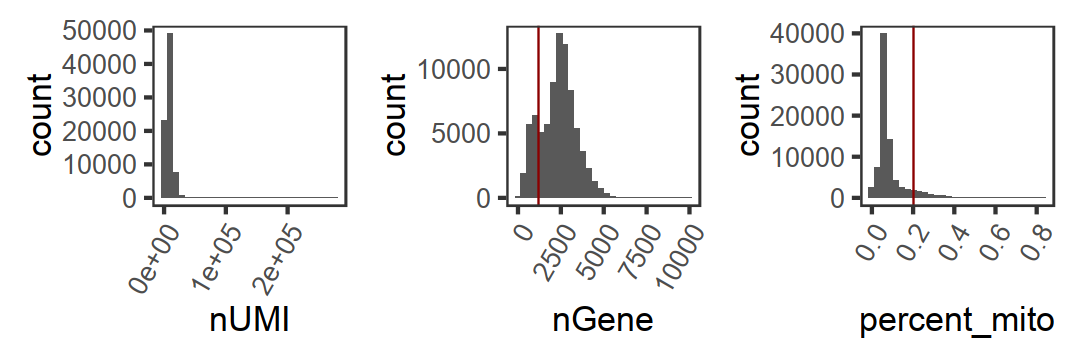

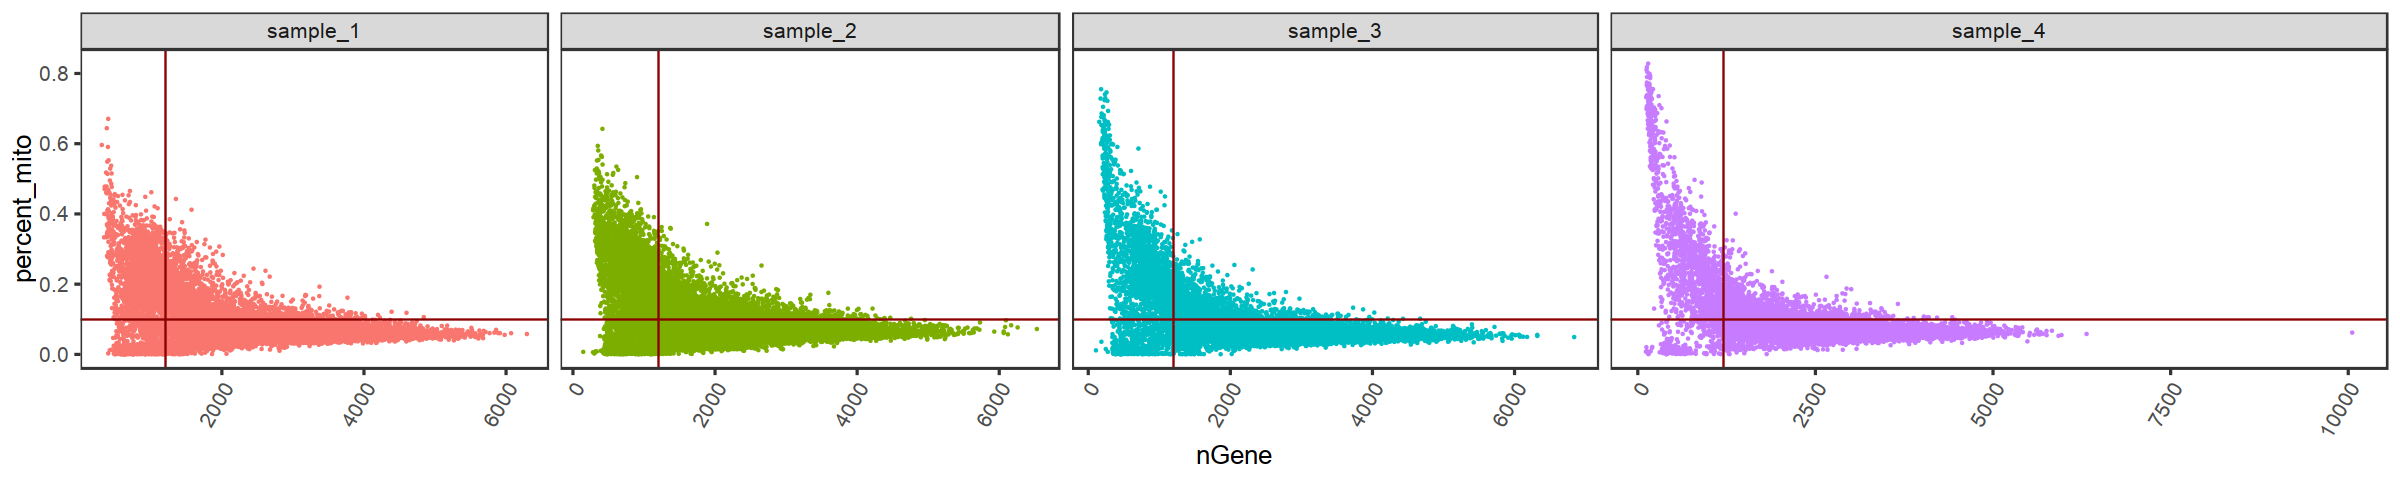

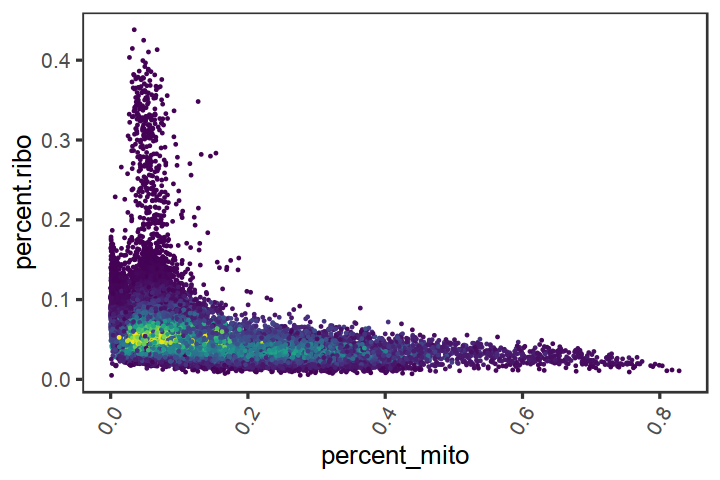

Warning message:
“Removed 1 rows containing missing values (geom_point).”

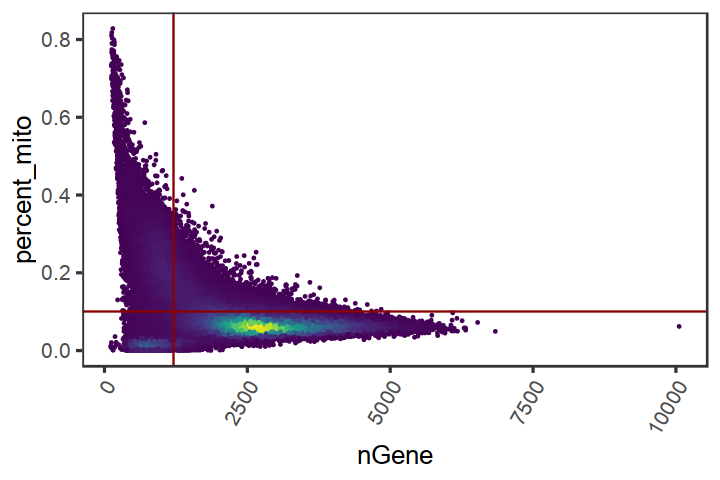

Warning message:
“Removed 1 rows containing missing values (geom_point).”

null device 
          1

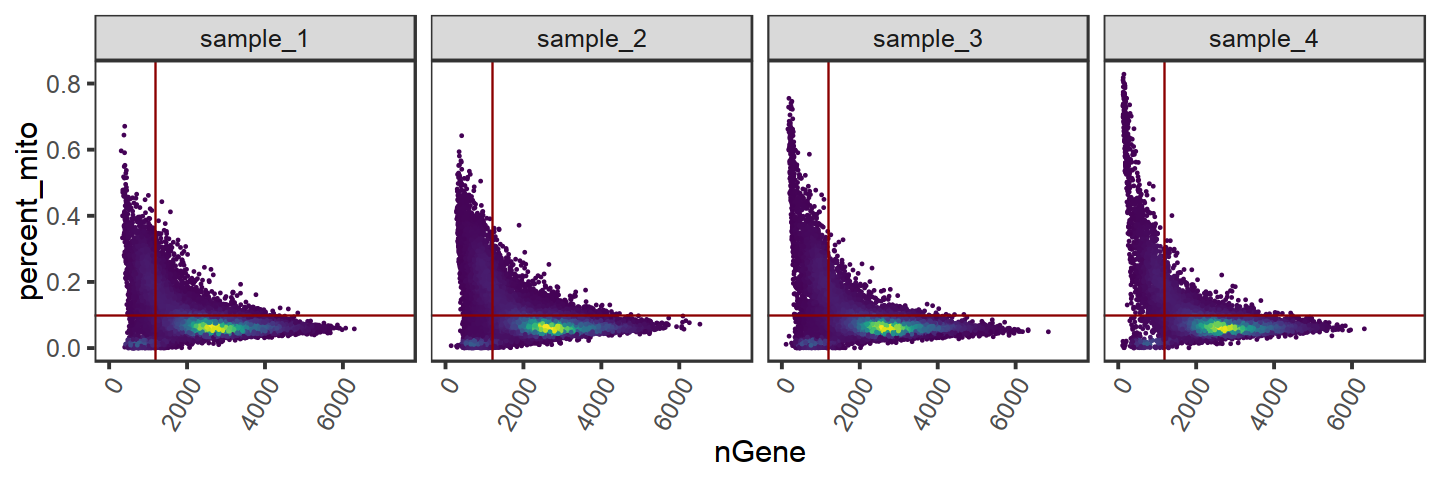

In [5]:
# Filter out cells with <= 500 genes, >= 0.2 mitochondrial genes
meta_all$nUMI <- Matrix::colSums(mRNA_exp_all)
meta_all$nGene <- Matrix::colSums(mRNA_exp_all > 0)
mito_genes <- grep("^MT-", rownames(mRNA_exp_all), value = TRUE, ignore.case = TRUE)
meta_all$percent_mito <- Matrix::colSums(mRNA_exp_all[mito_genes, ])/Matrix::colSums(mRNA_exp_all)
length(mito_genes)


## Ribosomal reads
genes_ribo <- grep("^RPS\\d+|^RPL\\d+", row.names(mRNA_exp_all), value = TRUE)
length(genes_ribo)
meta_all$percent.ribo <- Matrix::colSums(mRNA_exp_all[genes_ribo, meta_all$cell]) / 
                                        Matrix::colSums(mRNA_exp_all[, meta_all$cell])

fig.size(3,9)
(ggplot(meta_all) +
    geom_histogram(aes(x = nUMI))) +
        theme_bw(base_size = 20) +
        theme(text = element_text(size = 20),
            legend.position = "none",
    #         axis.text = element_blank(),
    #         axis.ticks = element_blank(),
            panel.grid = element_blank(),
          axis.text.x = element_text(angle = 60, hjust = 1)
              )+
(ggplot(meta_all) +
    geom_histogram(aes(x = nGene)) +
    geom_vline(xintercept = 1200, col = "darkred")) +
        theme_bw(base_size = 20) +
        theme(text = element_text(size = 20),
            legend.position = "none",
    #         axis.text = element_blank(),
    #         axis.ticks = element_blank(),
            panel.grid = element_blank(),
          axis.text.x = element_text(angle = 60, hjust = 1)
              ) +
(ggplot(meta_all) +
    geom_histogram(aes(x = percent_mito)) +
    geom_vline(xintercept = 0.2, col = "darkred")) +
        theme_bw(base_size = 20) +
        theme(text = element_text(size = 20),
            legend.position = "none",
    #         axis.text = element_blank(),
    #         axis.ticks = element_blank(),
            panel.grid = element_blank(),
          axis.text.x = element_text(angle = 60, hjust = 1)
              )
 ggsave(file = paste("post_QC_barplot", ".pdf", sep = ""), width = 15, height = 4, dpi = 300)

fig.size(4,20)
ggplot()+
    geom_point(
    data = meta_all,
    mapping = aes_string(x = "nGene", y = "percent_mito", fill = "sample"),
    size = 1, stroke = 0.0001, shape = 21
    ) +
#     scale_fill_manual(values = meta_colors$sample, name = "") +
    geom_vline(xintercept = 1200, col = "darkred") +
    geom_hline(yintercept = 0.1, col = "darkred") +
    facet_grid( ~ sample, scales = "free", space = "free_x") +
        theme_bw(base_size = 15) +
        theme(text = element_text(size = 15),
            legend.position = "none",
    #         axis.text = element_blank(),
    #         axis.ticks = element_blank(),
            panel.grid = element_blank(),
          axis.text.x = element_text(angle = 60, hjust = 1)
              )

library(MASS)
get_density <- function(x, y, ...) {
    dens <- MASS::kde2d(x, y, ...)
    ix <- findInterval(x, dens$x)
    iy <- findInterval(y, dens$y)
    ii <- cbind(ix,iy)
    return(dens$z[ii])
}

plot_dens <- get_density(meta_all$nGene, meta_all$percent.ribo, n = 100)
fig.size(4,6)
ggplot(meta_all, aes(x = percent_mito, y = percent.ribo, color = plot_dens)) +
    geom_point(size = .3) +
#     geom_hline(yintercept = 0.2, color = "darkred") +
#     geom_vline(xintercept = 1200, color = "darkred") +
    scale_color_viridis() +
    labs(color = "density") +
    theme_bw(base_size = 15) +
        theme(text = element_text(size = 15),
            legend.position = "none",
    #         axis.text = element_blank(),
    #         axis.ticks = element_blank(),
            panel.grid = element_blank(),
          axis.text.x = element_text(angle = 60, hjust = 1)
              )



plot_dens <- get_density(meta_all$nGene, meta_all$percent_mito, n = 100)
fig.size(4,6)
ggplot(meta_all, aes(x = nGene, y = percent_mito, color = plot_dens)) +
    geom_point(size = .3) +
    geom_hline(yintercept = 0.1, color = "darkred") +
    geom_vline(xintercept = 1200, color = "darkred") +
    scale_color_viridis() +
    labs(color = "density") +
    theme_bw(base_size = 15) +
        theme(text = element_text(size = 15),
            legend.position = "none",
    #         axis.text = element_blank(),
    #         axis.ticks = element_blank(),
            panel.grid = element_blank(),
          axis.text.x = element_text(angle = 60, hjust = 1)
              )


fig.size(4,12)
ggplot(meta_all, aes(x = nGene, y = percent_mito, color = plot_dens)) +
    geom_point(size = .3) +
    geom_hline(yintercept = 0.1, color = "darkred") +
    geom_vline(xintercept = 1200, color = "darkred") +
    facet_grid( ~ sample, scales = "free", space = "free_x") +
    scale_color_viridis() +
    xlim(0,7500) +
    labs(color = "density") +
    theme_bw(base_size = 18) +
        theme(text = element_text(size = 18),
            legend.position = "none",
    #         axis.text = element_blank(),
    #         axis.ticks = element_blank(),
            panel.grid = element_blank(),
            axis.text.x = element_text(angle = 60, hjust = 1)
              )
ggsave(file = paste("blood_nGene_nUMI", ".png", sep = ""), width = 12, height = 3, dpi = 500)
dev.off()

In [ ]:
plot_dens <- get_density(meta_all$nGene, meta_all$percent_mito, n = 100)
fig.size(1.5, 0.4)
ggplot(meta_all, aes(x = nGene, y = percent_mito, color = plot_dens)) +
    geom_point(size = .3) +
    geom_hline(yintercept = 0.1, color = "darkred") +
    geom_vline(xintercept = 1200, color = "darkred") +
    scale_color_viridis() +
    labs(color = "density") +
    theme_bw(base_size = 15) +
        theme(text = element_text(size = 0.1),
#             legend.position = "none",
    #         axis.text = element_blank(),
    #         axis.ticks = element_blank(),
            panel.grid = element_blank(),
          axis.text.x = element_text(angle = 60, hjust = 1)
              )

ggsave(file = paste("color_key_density_HTO", ".png", sep = ""), width = 0.4, height = 1.5, dpi = 200)
dev.off()

In [20]:
# QC

# I see the MT-high cells clustered together toward the center of the umap, so we may need use more stringent MT cutoff
meta_all <- subset(meta_all, nGene > 1200 & percent_mito < 0.1 & percent.ribo < 0.15) 
dim(meta_all)
table(meta_all$sample)

mRNA_exp_all <- mRNA_exp_all[, meta_all$cell]
adt_exp_all <- adt_exp_all[, meta_all$cell]


[1] 58486     6


sample_1 sample_2 sample_3 sample_4 
   14100    14762    14696    14928 

In [21]:
adt_exp_all <- adt_exp_all[, as.character(meta_all$cell)]
all(meta_all$cell == colnames(adt_exp_all))

[1] TRUE

In [22]:
hashtag_exp <- data.frame(cell = meta_all$cell,
                          hashtag1 = adt_exp_all[1,],
                          hashtag2 = adt_exp_all[2,],
                          hashtag4 = adt_exp_all[3,],
                          hashtag5 = adt_exp_all[4,],
                          hashtag6 = adt_exp_all[5,],
                          hashtag7 = adt_exp_all[6,],
                          hashtag8 = adt_exp_all[7,],
                          hashtag9 = adt_exp_all[8,],
                          hashtag12 = adt_exp_all[9,],
                          nGene = meta_all$nGene,
                          nUMI = meta_all$nUMI
                         )


max.ab.UMIs <- apply(hashtag_exp[,2:10], 1, max)/rowSums(hashtag_exp[,2:10])
# max.ab.UMIs[1:6]
ab.rat <- apply(hashtag_exp[,2:10], 1, function(x){(sort(x, decreasing = T)[2]/sum(x))/(sort(x, decreasing = T)[1]/sum(x))})
# ab.rat[1:6]
nUMI.hashtag <- apply(hashtag_exp[,2:10], 1, sum)
# nUMI.hashtag[1:6]

hashtag_exp$max.ab.UMIs <- max.ab.UMIs
hashtag_exp$ab.rat <- ab.rat
hashtag_exp$nUMI.hashtag <- nUMI.hashtag
head(hashtag_exp, 15)
dim(hashtag_exp)

,cell,hashtag1,hashtag2,hashtag4,hashtag5,hashtag6,hashtag7,hashtag8,hashtag9,hashtag12,nGene,nUMI,max.ab.UMIs,ab.rat,nUMI.hashtag
sample_1AAACCCAAGCGTCAAG,sample_1AAACCCAAGCGTCAAG,28,9,16,23,9,935,143,87,12,2383,8074,0.7408875,0.15294118,1262
sample_1AAACCCAAGCGTCTGC,sample_1AAACCCAAGCGTCTGC,27,818,9,22,11,10,36,11,8,2284,6375,0.8592437,0.04400978,952
sample_1AAACCCAAGGCAGTCA,sample_1AAACCCAAGGCAGTCA,47,26,10,127,140,43,51,44,12,1245,2769,0.2800000,0.90714286,500
sample_1AAACCCAAGTACGTCT,sample_1AAACCCAAGTACGTCT,2748,9,5,3,13,3,43,17,63,2576,8934,0.9462810,0.02292576,2904
sample_1AAACCCAAGTCTACCA,sample_1AAACCCAAGTCTACCA,65,12,11,7,17,33,78,737,29,3271,13752,0.7451972,0.10583446,989
sample_1AAACCCAAGTGCTACT,sample_1AAACCCAAGTGCTACT,31,587,13,36,52,34,142,42,25,2532,8150,0.6101871,0.24190801,962
sample_1AAACCCACAAACGTGG,sample_1AAACCCACAAACGTGG,9,300,3,1,3,1,14,6,5,1599,3521,0.8771930,0.04666667,342
sample_1AAACCCACAACTTCTT,sample_1AAACCCACAACTTCTT,156,729,11,35,44,55,89,90,1540,4357,19980,0.5602037,0.47337662,2749
sample_1AAACCCAGTGGATCGA,sample_1AAACCCAGTGGATCGA,46,9,1,1751,24,9,56,12,21,2795,11496,0.9077242,0.03198172,1929
sample_1AAACCCAGTGTTCGTA,sample_1AAACCCAGTGTTCGTA,2353,11,13,6,16,5,47,9,4,3734,16231,0.9549513,0.01997450,2464


[1] 58486    15

In [10]:
hashtag_exp[which(hashtag_exp$max.ab.UMIs < 0.75 & hashtag_exp$nUMI.hashtag > 100),][1:4,]

,cell,hashtag1,hashtag2,hashtag4,hashtag5,hashtag6,hashtag7,hashtag8,hashtag9,hashtag12,nGene,nUMI,max.ab.UMIs,ab.rat,nUMI.hashtag
sample_1AAACCCAAGCGTCAAG,sample_1AAACCCAAGCGTCAAG,28,9,16,23,9,935,143,87,12,2383,8074,0.7408875,0.1529412,1262
sample_1AAACCCAAGGCAGTCA,sample_1AAACCCAAGGCAGTCA,47,26,10,127,140,43,51,44,12,1245,2769,0.2800000,0.9071429,500
sample_1AAACCCAAGTCTACCA,sample_1AAACCCAAGTCTACCA,65,12,11,7,17,33,78,737,29,3271,13752,0.7451972,0.1058345,989
sample_1AAACCCAAGTGCTACT,sample_1AAACCCAAGTGCTACT,31,587,13,36,52,34,142,42,25,2532,8150,0.6101871,0.2419080,962


In [23]:
hashtag_exp$sample <- substring(hashtag_exp$cell, 1, 8)
table(hashtag_exp$sample)


sample_1 sample_2 sample_3 sample_4 
   14100    14762    14696    14928 

In [24]:
hashtag_exp %>%
  group_by(sample) %>%
  summarize(sum(nUMI))

sum(nUMI)
577804871


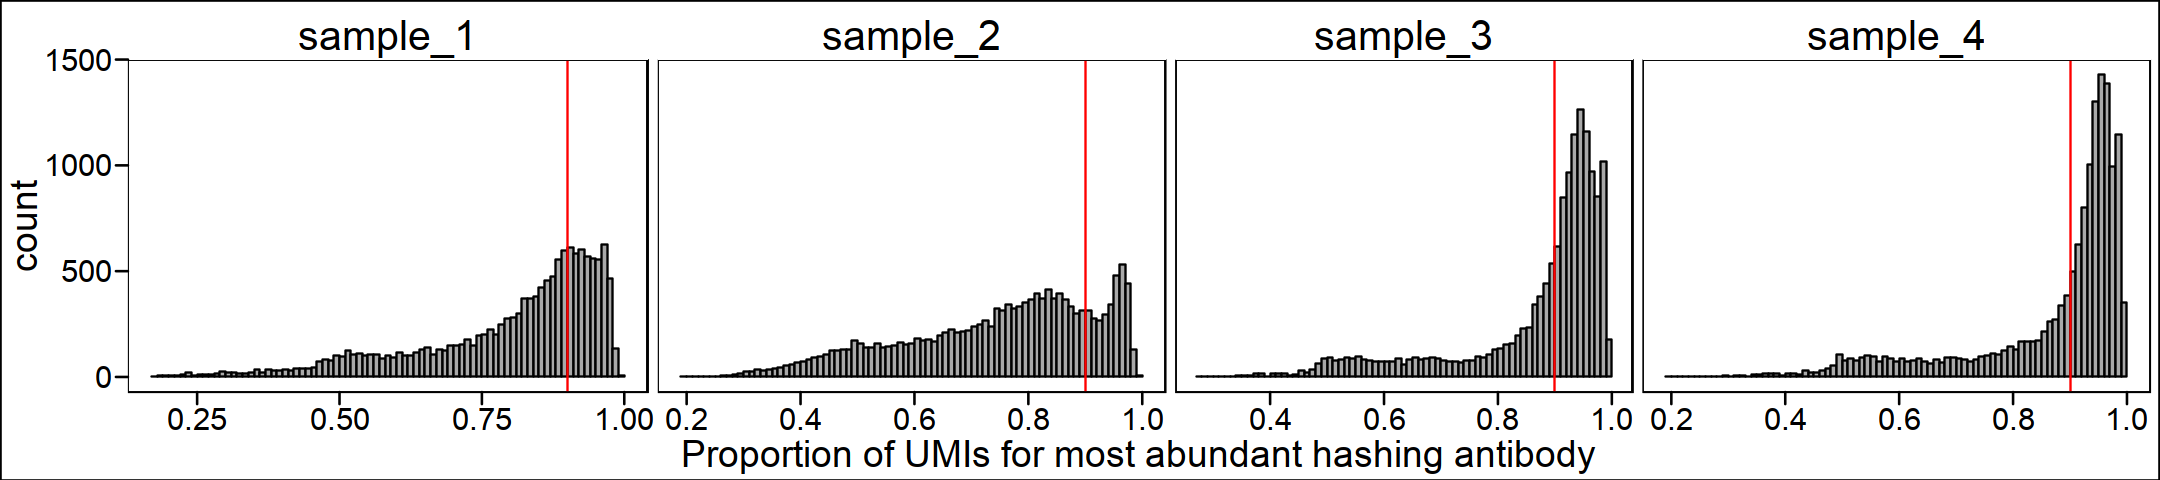

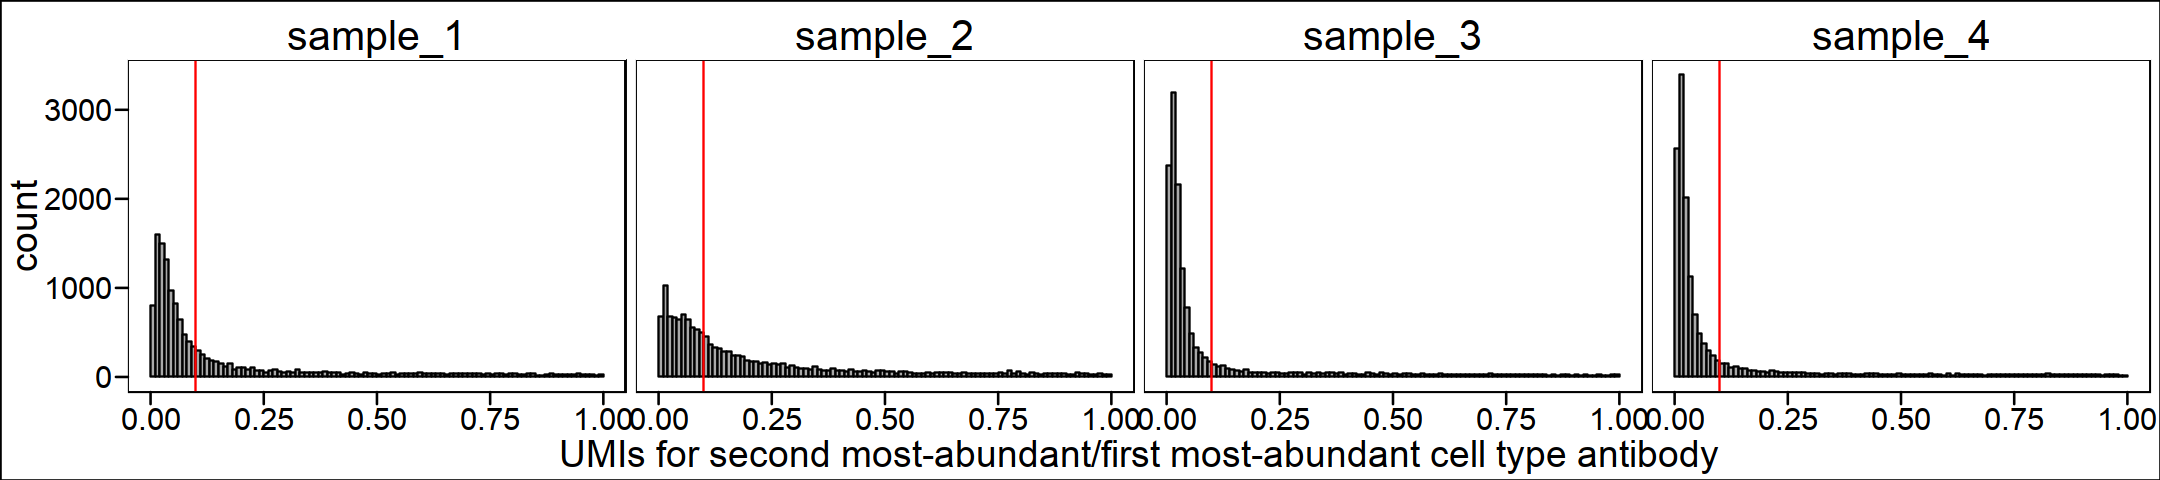

In [45]:
options(repr.plot.height = 4, repr.plot.width = 18)
ggplot(hashtag_exp, aes(x=max.ab.UMIs)) +
    geom_histogram(color="black", fill="darkgrey", binwidth = .01, boundary = 0.5) +
    facet_grid( ~ sample, scales = "free", space = "free_x") +
    xlab(label = "Proportion of UMIs for most abundant hashing antibody") +
    geom_vline(xintercept = 0.9, col = "red") +
    theme_base(base_size = 30) +
    theme(axis.text.x = element_text(size = 18), 
          axis.text.y=element_text(size=18), 
          axis.title.x = element_text(size=22),
          axis.title.y = element_text(size=22),
          legend.position = "none")
ggsave(file = paste("hto_qc_1", ".png", sep = ""), width = 20, height = 4, dpi = 200)


ggplot(hashtag_exp, aes(x=ab.rat)) +
    geom_histogram(color="black", fill="darkgrey", binwidth = .01, boundary = 0.5) +
    facet_grid( ~ sample, scales = "free", space = "free_x") +
    xlab(label = "UMIs for second most-abundant/first most-abundant cell type antibody") +
    geom_vline(xintercept = 0.10, col = "red") +
    theme_base(base_size = 30) +
    theme(axis.text.x = element_text(size = 18), 
          axis.text.y=element_text(size=18), 
          axis.title = element_text(size=22),
          legend.position = "none")
ggsave(file = paste("hto_qc_2", ".png", sep = ""), width = 20, height = 4, dpi = 200)


In [14]:
hashtag_final <- subset(hashtag_exp, max.ab.UMIs > 0.9 & ab.rat < 0.10)
cells_final <- hashtag_final$cell
length(cells_final)

hashtag_final$max <- apply(hashtag_final[,2:10], 1, max)
hashtag_final[1:4,]

[1] 26337

,cell,hashtag1,hashtag2,hashtag4,hashtag5,hashtag6,hashtag7,hashtag8,hashtag9,hashtag12,nGene,nUMI,max.ab.UMIs,ab.rat,nUMI.hashtag,sample,max
sample_1AAACCCAAGTACGTCT,sample_1AAACCCAAGTACGTCT,2748,9,5,3,13,3,43,17,63,2576,8934,0.9462810,0.02292576,2904,sample_1,2748
sample_1AAACCCAGTGGATCGA,sample_1AAACCCAGTGGATCGA,46,9,1,1751,24,9,56,12,21,2795,11496,0.9077242,0.03198172,1929,sample_1,1751
sample_1AAACCCAGTGTTCGTA,sample_1AAACCCAGTGTTCGTA,2353,11,13,6,16,5,47,9,4,3734,16231,0.9549513,0.01997450,2464,sample_1,2353
sample_1AAACCCATCGCACGGT,sample_1AAACCCATCGCACGGT,31,16,8,11,11,2031,29,15,19,2763,10483,0.9355136,0.01526342,2171,sample_1,2031


In [15]:
Samples <- c()
for (i in 1:nrow(hashtag_final)) { 

    if (hashtag_final[i,2] == hashtag_final[i, "max"]) {
        Sample <- "Hashtag1"    
    }
    
    if (hashtag_final[i,3] == hashtag_final[i,"max"]) {
        Sample <- "Hashtag2"    
    }
    
    if (hashtag_final[i,4] == hashtag_final[i,"max"]) {
        Sample <- "Hashtag4"    
    }
    
    if (hashtag_final[i,5] == hashtag_final[i, "max"]) {
        Sample <- "Hashtag5"    
    }
    
    if (hashtag_final[i,6] == hashtag_final[i,"max"]) {
        Sample <- "Hashtag6"    
    }
    
    if (hashtag_final[i,7] == hashtag_final[i,"max"]) {
        Sample <- "Hashtag7"    
    }
    if (hashtag_final[i,8] == hashtag_final[i, "max"]) {
        Sample <- "Hashtag8"    
    }
    
    if (hashtag_final[i,9] == hashtag_final[i,"max"]) {
        Sample <- "Hashtag9"    
    }
    
    if (hashtag_final[i,10] == hashtag_final[i,"max"]) {
        Sample <- "Hashtag12"    
    }  
    
    Samples[i] <- Sample
    
}

length(Samples)
hashtag_final$max_hash <- Samples

[1] 26337

In [16]:
hashtag_final[1:4,]
table(hashtag_final$max_hash)

,cell,hashtag1,hashtag2,hashtag4,hashtag5,hashtag6,hashtag7,hashtag8,hashtag9,hashtag12,nGene,nUMI,max.ab.UMIs,ab.rat,nUMI.hashtag,sample,max,max_hash
sample_1AAACCCAAGTACGTCT,sample_1AAACCCAAGTACGTCT,2748,9,5,3,13,3,43,17,63,2576,8934,0.9462810,0.02292576,2904,sample_1,2748,Hashtag1
sample_1AAACCCAGTGGATCGA,sample_1AAACCCAGTGGATCGA,46,9,1,1751,24,9,56,12,21,2795,11496,0.9077242,0.03198172,1929,sample_1,1751,Hashtag5
sample_1AAACCCAGTGTTCGTA,sample_1AAACCCAGTGTTCGTA,2353,11,13,6,16,5,47,9,4,3734,16231,0.9549513,0.01997450,2464,sample_1,2353,Hashtag1
sample_1AAACCCATCGCACGGT,sample_1AAACCCATCGCACGGT,31,16,8,11,11,2031,29,15,19,2763,10483,0.9355136,0.01526342,2171,sample_1,2031,Hashtag7



 Hashtag1 Hashtag12  Hashtag2  Hashtag4  Hashtag5  Hashtag6  Hashtag7  Hashtag8 
     5442      2851      1836      1162      3086      3047      2350      4375 
 Hashtag9 
     2188 

In [17]:
meta_qc <- meta_all[which(meta_all$cell %in% hashtag_final$cell),]
all(meta_qc$cell == hashtag_final$cell)
meta_qc$condition <- hashtag_final$max_hash
meta_qc$max.ab.UMIs <- hashtag_final$max.ab.UMIs
meta_qc$ab.rat <- hashtag_final$ab.rat
meta_qc$cell <- as.character(meta_qc$cell)
meta_qc[1:4,]

[1] TRUE

,cell,sample,nUMI,nGene,percent_mito,percent.ribo,condition,max.ab.UMIs,ab.rat
5,sample_1AAACCCAAGTACGTCT,sample_1,8934,2576,0.06413700,0.05417506,Hashtag1,0.9462810,0.02292576
16,sample_1AAACCCAGTGGATCGA,sample_1,11496,2795,0.06584899,0.09351079,Hashtag5,0.9077242,0.03198172
17,sample_1AAACCCAGTGTTCGTA,sample_1,16231,3734,0.05791387,0.08255807,Hashtag1,0.9549513,0.01997450
21,sample_1AAACCCATCGCACGGT,sample_1,10483,2763,0.05904798,0.05513689,Hashtag7,0.9355136,0.01526342


In [161]:
mRNA_exp_qc <- mRNA_exp_all[, meta_qc$cell]
all(colnames(mRNA_exp_qc) == meta_qc$cell)
dim(mRNA_exp_qc)

# saveRDS(mRNA_exp_qc, "qc_mRNA_HTO_exp_all_nGene1000_MT0.1_max.ab.UMIs_0.90_ab.rat_0.10_2020-04-15.rds") 
# saveRDS(meta_qc, "qc_mRNA_HTO_meta_all_nGene1000_MT0.1_max.ab.UMIs_0.90_ab.rat_0.10__2020-04-15.rds")

[1] TRUE

[1] 33538 26337

In [19]:
# Use the cell_use to remove the tiny ribosome cluster and a cluster of mixture of all conditions
cell_use <- readRDS("cell_use_2020-04-15.rds")
meta_qc <- meta_qc[which(meta_qc$cell %in% cell_use),]
mRNA_exp_qc <- mRNA_exp_all[, meta_qc$cell]
all(colnames(mRNA_exp_qc) == meta_qc$cell)
dim(mRNA_exp_qc)

class(mRNA_exp_qc)

[1] TRUE

[1] 33538 25823

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

## Clustering and downstream anlaysis

In [21]:
## Normalize
exprs_norm <- mRNA_exp_qc %>% NormalizeDataSeurat()

# Find varible genes
genes_exclude <- grep("^MT-|^RPL|^RPS|MALAT1|MIR-", row.names(exprs_norm), value = TRUE)
meta_qc$sample <- as.character(meta_qc$sample)
meta_qc$cell <- as.character(meta_qc$cell)

vargenes_df <- FindVariableGenesBatch(exprs_norm, meta_qc, genes_exclude, 1e3)
nrow(vargenes_df)
table(vargenes_df$N)
var_genes <- vargenes_df$gene
head(var_genes)


# Scale expression to z-scores across cell types
exprs_scaled <- exprs_norm[var_genes, ] %>% ScaleDataSeurat() 

# Cosine-normalize expression
exprs_cosine <- exprs_scaled %>% cosine_normalize(2)

# PCA for top 20 PCs
pca_res <- irlba::prcomp_irlba(t(exprs_cosine), 20)
# system.time({pca_cos <- rARPACK::svds(exprs_cosine, 50, 0, 50)})

[1] 1313


  1   2   3   4 
269 141 163 740 

[1] "FTH1"  "CCL17" "CCL18" "PPBP"  "MT2A"  "FTL"

Harmony 1/10
Harmony 2/10
Harmony 3/10
Harmony 4/10
Harmony 5/10
Harmony 6/10
Harmony 7/10
Harmony 8/10
Harmony 9/10
Harmony 10/10


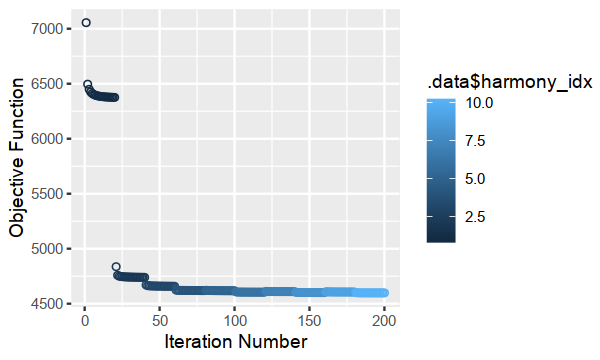

In [22]:
# Harmonization: sample
options(repr.plot.height = 3, repr.plot.width = 5)
harmony <- HarmonyMatrix(pca_res$x, meta_qc, do_pca=FALSE, 
                         "sample", theta = 2,
                         # lambda = 1, # Not sure what lambda affects
                         # tau = 10, 
                         epsilon.cluster = -Inf,
                         epsilon.harmony = -Inf,
                         max.iter.cluster = 20,
                         max.iter.harmony = 10,
                         plot_convergence = T)

In [23]:
colnames(harmony) <- paste0("harmonized_", colnames(harmony), sep="")
meta_qc <- cbind(meta_qc, harmony)

In [24]:
# UMAP with top 20 PCs
library(umap)
umap_res <- umap(harmony[, c(1:20)], n_neighbors = 30, metric = "cosine", min_dist = .1)
meta_qc$harmonized_UMAP1 <- umap_res$layout[, 1]
meta_qc$harmonized_UMAP2 <- umap_res$layout[, 2]
meta_qc[1:4,]

saveRDS(meta_qc, "qc_meta_all_nGene1200_MT0.1_umap_max.ab.UMIs_0.90_ab.rat_0.10_cell_use_2020-04-15.rds")

,cell,sample,nUMI,nGene,percent_mito,percent.ribo,condition,max.ab.UMIs,ab.rat,stim,...,harmonized_PC13,harmonized_PC14,harmonized_PC15,harmonized_PC16,harmonized_PC17,harmonized_PC18,harmonized_PC19,harmonized_PC20,harmonized_UMAP1,harmonized_UMAP2
5,sample_1AAACCCAAGTACGTCT,sample_1,8934,2576,0.06413700,0.05417506,Hashtag1,0.9462810,0.02292576,TNF+ IFNg+ Fib+,...,0.01648613,0.03202862,0.04188900,0.060870476,-0.04613398,0.0590017661,0.01243972,-0.00244468,-1.555130,7.885971
16,sample_1AAACCCAGTGGATCGA,sample_1,11496,2795,0.06584899,0.09351079,Hashtag5,0.9077242,0.03198172,IFNg+ Fib+,...,0.11870761,-0.06221793,-0.00705386,0.002039986,-0.12566311,0.0282471354,-0.04096509,-0.01100320,-4.141892,8.808210
17,sample_1AAACCCAGTGTTCGTA,sample_1,16231,3734,0.05791387,0.08255807,Hashtag1,0.9549513,0.01997450,TNF+ IFNg+ Fib+,...,-0.05023030,-0.02619716,-0.11898049,0.097446607,0.03337014,-0.0001666951,0.02365825,-0.05956842,-6.254646,4.889517
21,sample_1AAACCCATCGCACGGT,sample_1,10483,2763,0.05904798,0.05513689,Hashtag7,0.9355136,0.01526342,IFNg+,...,-0.14814478,0.10886677,-0.11290886,0.028333773,-0.06509215,-0.0041988074,-0.06821975,0.08321472,1.463839,-5.163644


In [25]:
saveRDS(exprs_norm, "qc_mRNA_exprs_norm_nGene1200_MT0.1_umap_max.ab.UMIs_0.90_ab.rat_0.10_cell_use_2020-04-15.rds")

# Load the results

In [93]:
meta_qc <- readRDS("qc_meta_all_cluster_trajectory_nGene1200_MT0.1_umap_max.ab.UMIs_0.90_ab.rat_0.10_cell_use_correctlabel_2020-04-19.rds")
table(meta_qc$condition)

meta_qc$stim[which(meta_qc$stim == "IFNr+")] <- "IFNg+"
meta_qc$stim[which(meta_qc$stim == "IFNr+ fibro+")] <- "IFNg+ fibro+"
meta_qc$stim[which(meta_qc$stim == "TNFa+ IFNr+")] <- "TNFa+ IFNg+"
meta_qc$stim[which(meta_qc$stim == "TNFa+ IFNr+ fibro+")] <- "TNFa+ IFNg+ fibro+"
table(meta_qc$stim)

# exprs_norm <- readRDS("qc_mRNA_exprs_norm_nGene1200_MT0.1_umap_max.ab.UMIs_0.90_ab.rat_0.10_cell_use_2020-04-15.rds")


 Hashtag1 Hashtag12  Hashtag2  Hashtag4  Hashtag5  Hashtag6  Hashtag7  Hashtag8 
     5396      2829      1808      1132      3043      2966      2281      4241 
 Hashtag9 
     2127 


           Control              IFNb+              IFNg+       IFNg+ fibro+ 
              5396               1808               2966               2281 
              IL4+              TNFa+       TNFa+ fibro+        TNFa+ IFNg+ 
              1132               2829               3043               4241 
TNFa+ IFNg+ fibro+ 
              2127 

In [94]:
dim(meta_qc)
table(meta_qc$sample)

[1] 25823    39


sample_1 sample_2 sample_3 sample_4 
    4622     3027     8775     9399 

In [100]:
# Map real stimulated conditions

# Concentrations were:
# 200pg/ml IFN-beta
# 20ng/ml IL-4
# 20ng/ml TNF-alpha
# 5ng/ml IFN-gamma


meta_qc$stim <- meta_qc$condition
meta_qc$stim[which(meta_qc$stim == "Hashtag1")] <-  "Control"
meta_qc$stim[which(meta_qc$stim == "Hashtag2")] <-  "IFNb+"
meta_qc$stim[which(meta_qc$stim == "Hashtag4")] <-  "TNFa+"
meta_qc$stim[which(meta_qc$stim == "Hashtag5")] <-  "TNFa+ fibro+"
meta_qc$stim[which(meta_qc$stim == "Hashtag6")] <-  "IFNg+"
meta_qc$stim[which(meta_qc$stim == "Hashtag7")] <-  "IFNg+ fibro+"
meta_qc$stim[which(meta_qc$stim == "Hashtag8")] <-  "TNFa+ IFNg+"
meta_qc$stim[which(meta_qc$stim == "Hashtag9")] <- "TNFa+ IFNg+ fibro+"
meta_qc$stim[which(meta_qc$stim == "Hashtag12")] <- "IL4+"
names(table(meta_qc$stim))

[1] "Control"            "IFNb+"              "IFNg+"             
[4] "IFNg+ fibro+"       "IL4+"               "TNFa+"             
[7] "TNFa+ fibro+"       "TNFa+ IFNg+"        "TNFa+ IFNg+ fibro+"

In [105]:
# saveRDS(meta_qc, "qc_meta_all_cluster_trajectory_nGene1200_MT0.1_umap_max.ab.UMIs_0.90_ab.rat_0.10_cell_use_correctlabel_2020-05-11.rds")

In [2]:
meta_qc <- readRDS("qc_meta_all_cluster_trajectory_nGene1200_MT0.1_umap_max.ab.UMIs_0.90_ab.rat_0.10_cell_use_correctlabel_2020-05-11.rds")

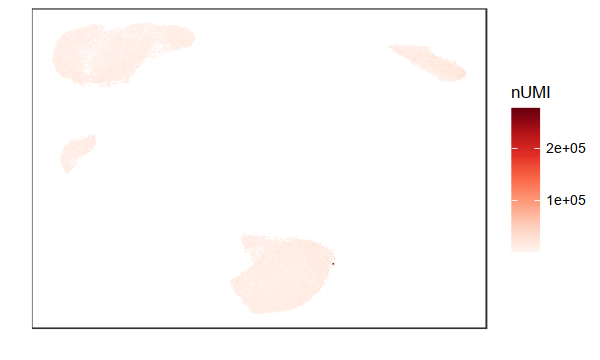

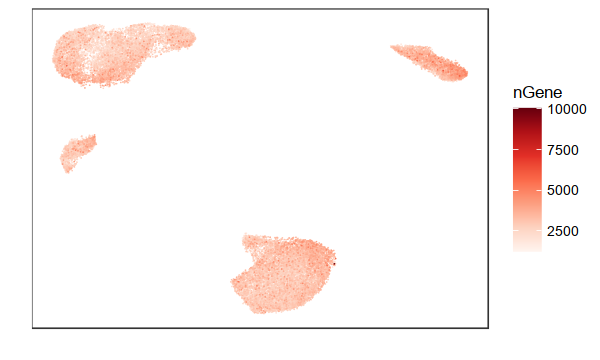

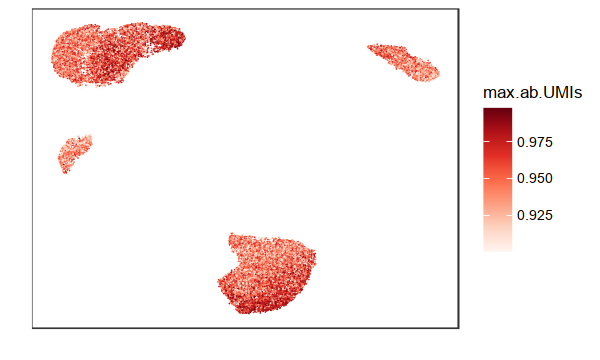

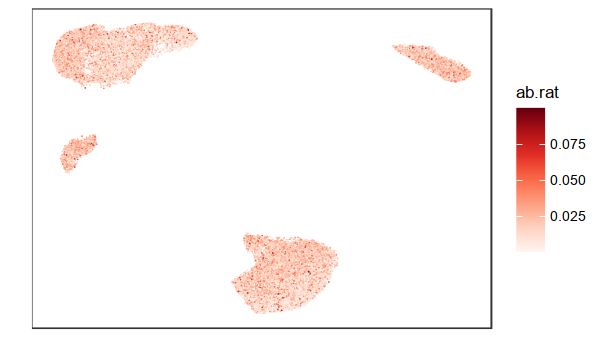

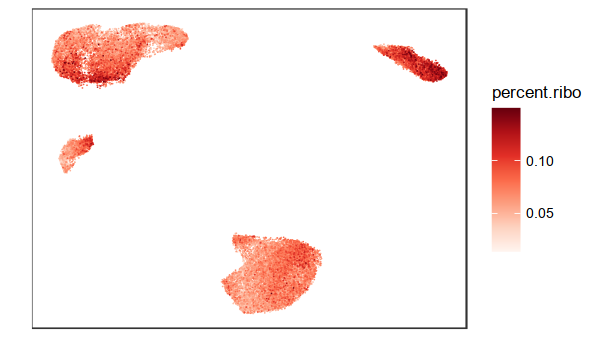

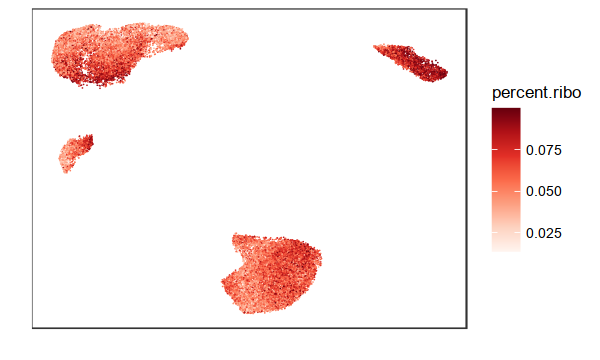

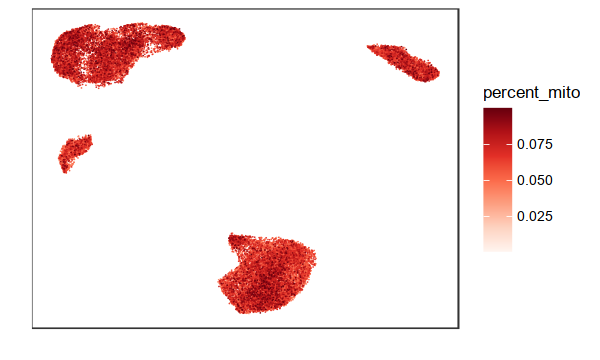

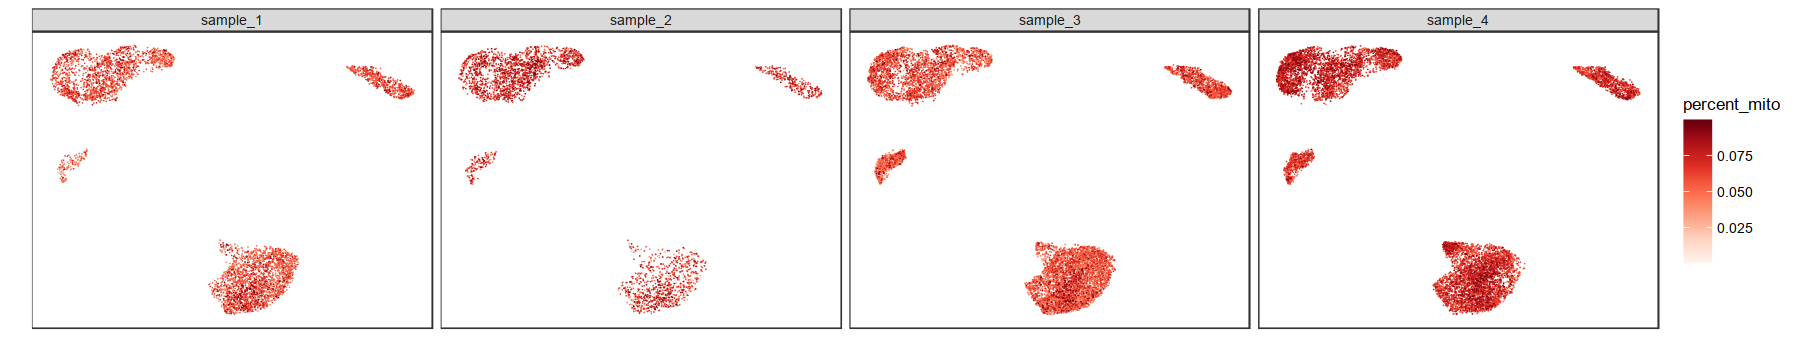

In [3]:
options(repr.plot.height = 3, repr.plot.width = 5)
ggplot() +
  geom_point(
#   data = meta_qc,
    data = meta_qc[order(meta_qc$nUMI),],
    mapping = aes_string(x = "harmonized_UMAP1", y = "harmonized_UMAP2", fill = "nUMI"),
    size = 0.2, stroke = 0.0001, shape = 21
  ) +
  scale_fill_gradientn(
      colours = colorRampPalette(RColorBrewer::brewer.pal(9, "Reds"))(7)[1:7],
      name = "nUMI"
  ) +
  labs(
      x = "",
      y = ""
      ) +
  theme_bw(base_size = 10) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=22, face = "italic")
  )

options(repr.plot.height = 3, repr.plot.width = 5)
ggplot() +
  geom_point(
    data = meta_qc[order(meta_qc$nGene),],
    mapping = aes_string(x = "harmonized_UMAP1", y = "harmonized_UMAP2", fill = "nGene"),
    size = 0.2, stroke = 0.0001, shape = 21
  ) +
  scale_fill_gradientn(
      colours = colorRampPalette(RColorBrewer::brewer.pal(9, "Reds"))(7)[1:7],
      name = "nGene"
  ) +
  labs(
      x = "",
      y = ""
      ) +
  theme_bw(base_size = 10) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=22, face = "italic")
  )


ggplot() +
  geom_point(
    data = meta_qc[sample(nrow(meta_qc)),],
    mapping = aes_string(x = "harmonized_UMAP1", y = "harmonized_UMAP2", fill = "max.ab.UMIs"),
    size = 0.2, stroke = 0.0001, shape = 21
  ) +
  scale_fill_gradientn(
      colours = colorRampPalette(RColorBrewer::brewer.pal(9, "Reds"))(7)[1:7],
      name = "max.ab.UMIs"
  ) +
  labs(
      x = "",
      y = ""
      ) +
  theme_bw(base_size = 10) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=22, face = "italic")
  )

ggplot() +
  geom_point(
    data = meta_qc[sample(nrow(meta_qc)),],
    mapping = aes_string(x = "harmonized_UMAP1", y = "harmonized_UMAP2", fill = "ab.rat"),
    size = 0.2, stroke = 0.0001, shape = 21
  ) +
  scale_fill_gradientn(
      colours = colorRampPalette(RColorBrewer::brewer.pal(9, "Reds"))(7)[1:7],
      name = "ab.rat"
  ) +
  labs(
      x = "",
      y = ""
      ) +
  theme_bw(base_size = 10) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=22, face = "italic")
  )

ggplot() +
  geom_point(
    data = meta_qc[order(meta_qc$percent.ribo),],
    mapping = aes_string(x = "harmonized_UMAP1", y = "harmonized_UMAP2", fill = "percent.ribo"),
    size = 0.2, stroke = 0.0001, shape = 21
  ) +
  scale_fill_gradientn(
      colours = colorRampPalette(RColorBrewer::brewer.pal(9, "Reds"))(7)[1:7],
      name = "percent.ribo"
  ) +
  labs(
      x = "",
      y = ""
      ) +
  theme_bw(base_size = 10) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=22, face = "italic")
  )


ggplot() +
  geom_point(
    data = meta_qc[-which(meta_qc$percent.ribo > 0.1),],
    mapping = aes_string(x = "harmonized_UMAP1", y = "harmonized_UMAP2", fill = "percent.ribo"),
    size = 0.2, stroke = 0.0001, shape = 21
  ) +
  scale_fill_gradientn(
      colours = colorRampPalette(RColorBrewer::brewer.pal(9, "Reds"))(7)[1:7],
      name = "percent.ribo"
  ) +
  labs(
      x = "",
      y = ""
      ) +
  theme_bw(base_size = 10) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=22, face = "italic")
  )



options(repr.plot.height = 3, repr.plot.width = 5)
ggplot() +
  geom_point(
    data = meta_qc[order(meta_qc$percent_mito),],
    mapping = aes_string(x = "harmonized_UMAP1", y = "harmonized_UMAP2", fill = "percent_mito"),
    size = 0.2, stroke = 0.0001, shape = 21
  ) +
  scale_fill_gradientn(
      colours = colorRampPalette(RColorBrewer::brewer.pal(9, "Reds"))(7)[1:7],
      name = "percent_mito"
  ) +
  labs(
      x = "",
      y = ""
      ) +
  theme_bw(base_size = 10) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=22, face = "italic")
  )


options(repr.plot.height = 3, repr.plot.width = 15)
ggplot() +
  geom_point(
    data = meta_qc[order(meta_qc$percent_mito),],
    mapping = aes_string(x = "harmonized_UMAP1", y = "harmonized_UMAP2", fill = "percent_mito"),
    size = 0.2, stroke = 0.0001, shape = 21
  ) +
  facet_grid( ~ sample) +
  scale_fill_gradientn(
      colours = colorRampPalette(RColorBrewer::brewer.pal(9, "Reds"))(7)[1:7],
      name = "percent_mito"
  ) +
  labs(
      x = "",
      y = ""
      ) +
  theme_bw(base_size = 10) +
  theme(
#     legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=22, face = "italic")
  )


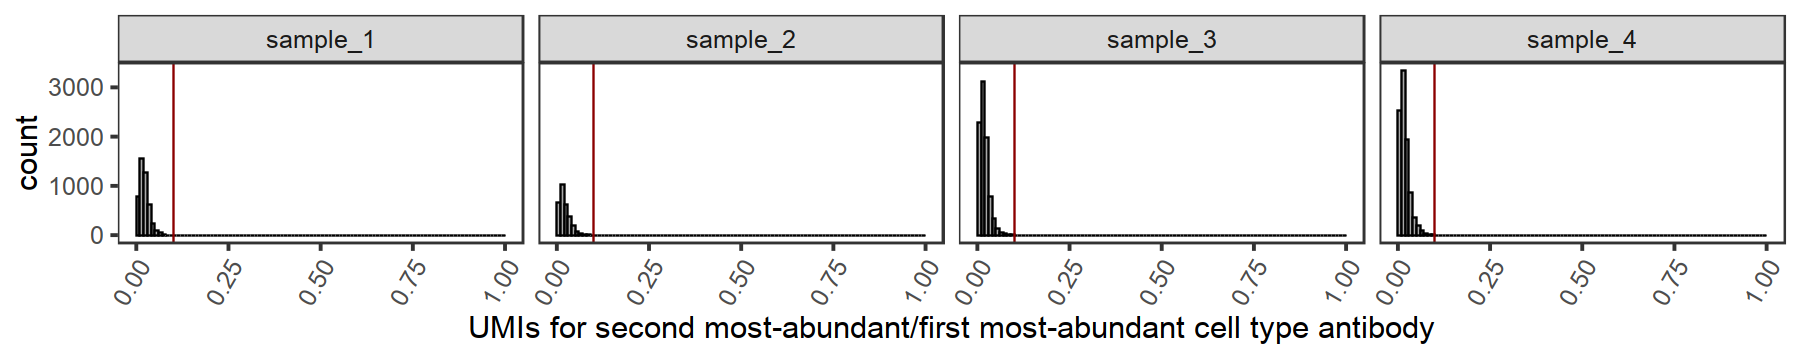

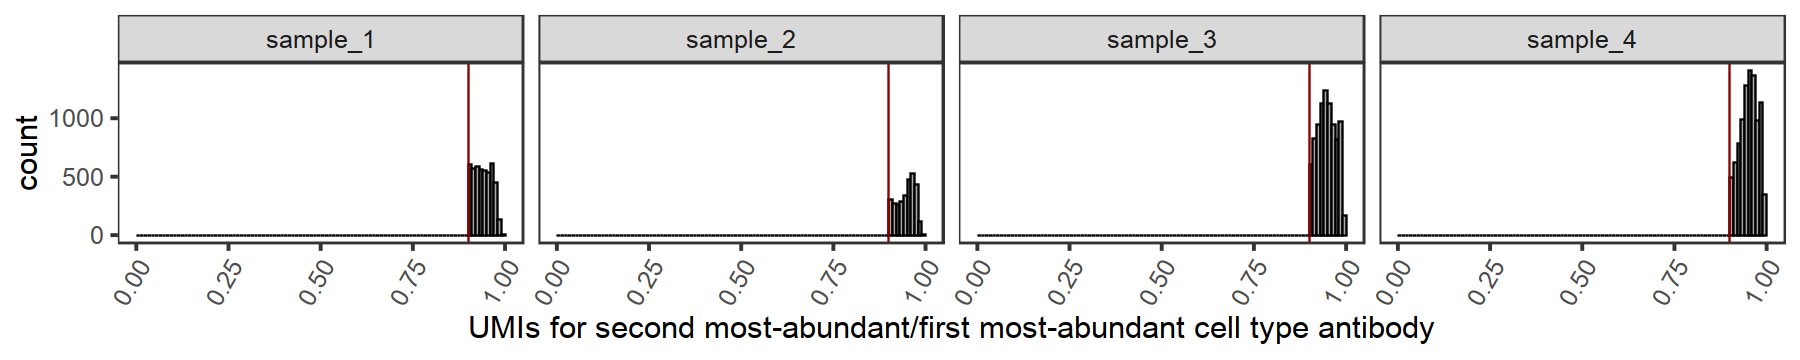

In [52]:
options(repr.plot.height = 3, repr.plot.width = 15)
ggplot(meta_qc, aes(x=ab.rat)) +
    geom_histogram(color="black", fill="darkgrey", binwidth = 0.01, boundary = 0.5) +
    facet_grid( ~ sample, scales = "free", space = "free_x") +
    xlim(0,1) +
    xlab(label = "UMIs for second most-abundant/first most-abundant cell type antibody") +
    geom_vline(xintercept = 0.10, col = "darkred") +
    theme_bw(base_size = 18) +
    theme(text = element_text(size = 18),
            legend.position = "none",
    #         axis.text = element_blank(),
    #         axis.ticks = element_blank(),
            panel.grid = element_blank(),
            axis.text.x = element_text(angle = 60, hjust = 1)
    )
ggsave(file = paste("blood_ab.rat", ".png", sep = ""), width = 15, height = 3, dpi = 500)



options(repr.plot.height = 3, repr.plot.width = 15)
ggplot(meta_qc, aes(x=max.ab.UMIs)) +
    geom_histogram(color="black", fill="darkgrey", binwidth = 0.01, boundary = 0.5) +
    facet_grid( ~ sample, scales = "free", space = "free_x") +
    xlim(0,1) +
    xlab(label = "UMIs for second most-abundant/first most-abundant cell type antibody") +
    geom_vline(xintercept = 0.90, col = "darkred") +
    theme_bw(base_size = 18) +
    theme(text = element_text(size = 18),
            legend.position = "none",
    #         axis.text = element_blank(),
    #         axis.ticks = element_blank(),
            panel.grid = element_blank(),
            axis.text.x = element_text(angle = 60, hjust = 1)
    )
ggsave(file = paste("blood_max.ab.UMIs", ".png", sep = ""), width = 15, height = 3, dpi = 500)


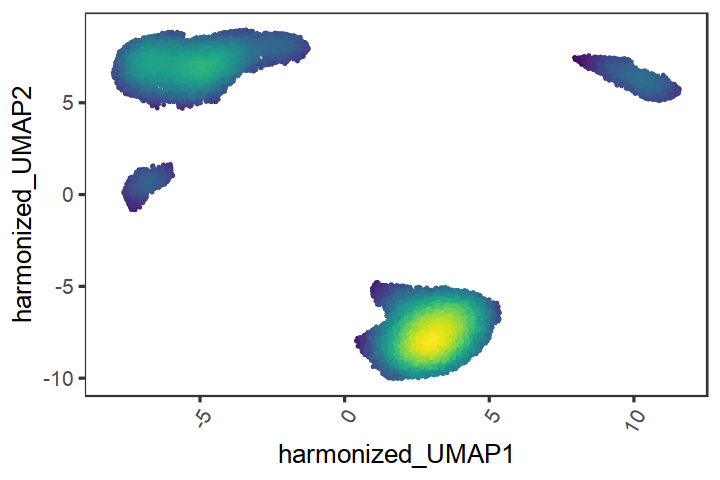

In [31]:
library(MASS)
get_density <- function(x, y, ...) {
    dens <- MASS::kde2d(x, y, ...)
    ix <- findInterval(x, dens$x)
    iy <- findInterval(y, dens$y)
    ii <- cbind(ix,iy)
    return(dens$z[ii])
}

plot_dens <- get_density(meta_qc$harmonized_UMAP1, meta_qc$harmonized_UMAP2, n = 100)
fig.size(4,6)
ggplot(meta_qc, aes(x = harmonized_UMAP1, y = harmonized_UMAP2, color = plot_dens)) +
    geom_point(size = .3) +
    scale_color_viridis() +
    labs(color = "density") +
    theme_bw(base_size = 15) +
        theme(text = element_text(size = 15),
            legend.position = "none",
    #         axis.text = element_blank(),
    #         axis.ticks = element_blank(),
            panel.grid = element_blank(),
          axis.text.x = element_text(angle = 60, hjust = 1)
              )


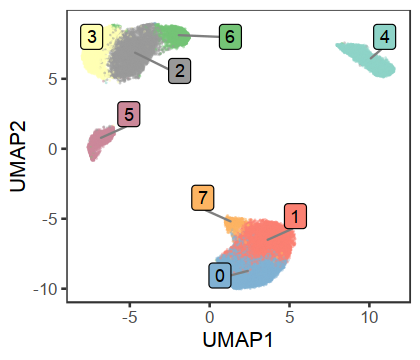

In [6]:
meta_qc$res_0.60 <- as.character(meta_qc$res_0.60)
cluster_center <- meta_qc %>%
                  group_by(res_0.60) %>%
                  summarise_at(vars(harmonized_UMAP1, harmonized_UMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)
cluster_center$res_0.60 <- as.character(cluster_center$res_0.60)

options(repr.plot.height = 3, repr.plot.width = 3.5)
ggplot(meta_qc[sample(nrow(meta_qc)),],
       aes(x = harmonized_UMAP1, y = harmonized_UMAP2, fill= res_0.60)
      ) +
  geom_point(size = 0.5, stroke = 0.0001, shape = 21, alpha = 0.5) +
  geom_label_repel(
    data = cluster_center,
    aes(label = res_0.60),
#     fontface = 'bold', 
    size = 3.7, 
    box.padding = unit(0.6, "lines"),
    point.padding = unit(0.2, "lines"),
    segment.color = 'grey50'
  ) +
  scale_fill_manual(values = meta_colors$cluster, name = "") +
  labs(
      x = "UMAP1",
      y = "UMAP2"
      ) +
  theme_bw(base_size = 12) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=22, face = "italic")
  )

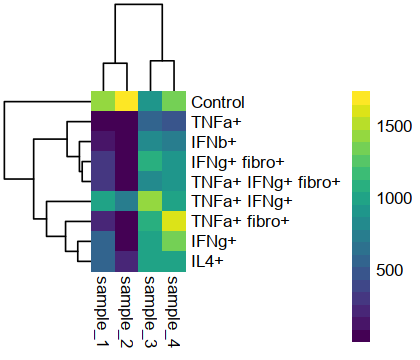

In [102]:
temp <- table(meta_qc$sample, meta_qc$stim)
mat_breaks <- seq(min(temp), max(temp), length.out = 10)
quantile_breaks <- function(xs, n = 10) {
  breaks <- quantile(xs, probs = seq(0, 1, length.out = n))
  breaks[!duplicated(breaks)]
}
mat_breaks <- quantile_breaks(temp, n = 10)

scale_rows <- function(x) t(scale(t(x)))
mat <- temp
# mat <- scale_rows(temp) # Z-score
# mat[mat > 2] <- 2
# mat[mat < -2] <- -2

options(repr.plot.width = 3.5, repr.plot.height = 3)
pheatmap(
  mat = t(mat),
  border_color = NA,
#   breaks  = mat_breaks,
  color  = viridis(20),
  show_rownames = TRUE,
  show_colnames = TRUE,
  cluster_rows = TRUE,
  cluster_cols = TRUE,
#   annotation_col = annotation_col,
#   annotation_colors = meta_colors,
  fontsize = 10,
  fontsize_row = 10
#   scale = "none"
)

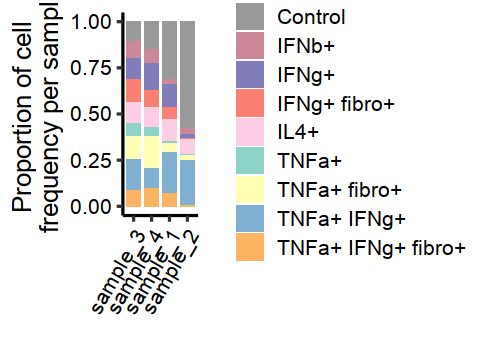

null device 
          1

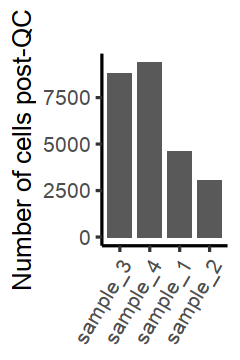

In [27]:
temp <- as.data.frame(table(meta_qc$sample, meta_qc$stim))
colnames(temp) <- c("sample", "stim", "freq")
temp$sample <- factor(temp$sample, levels = c("sample_3", "sample_4", "sample_1", "sample_2"))

options(repr.plot.height = 3, repr.plot.width = 4)
ggplot(
      temp,
      aes(x = sample, y=freq, fill = stim)
      ) + 
#     coord_flip() +
    geom_bar(stat = "identity", 
             position = "fill", 
             width = 0.8) +
#     facet_grid(dataset ~ . , scales = "free", space = "free_x") +
    scale_fill_manual("", values = meta_colors$stim) +
    labs(x = "", y = "Proportion of cell \n frequency per sample") + 
#     coord_flip() +
  theme_classic(base_size = 15) +
  theme(
#     legend.position = "none",
      axis.text.x = element_text(angle = 60, hjust = 1),
#     axis.ticks = element_blank(),
      axis.text = element_text(color = "black"),
    panel.grid = element_blank()
  ) 




temp = data.frame(
  sample = names(table(meta_qc$sample)),
  num_cells = as.numeric(table(meta_qc$sample))
)
temp$sample <- factor(temp$sample, levels = c("sample_3", "sample_4", "sample_1", "sample_2"))

options(repr.plot.height = 3, repr.plot.width = 2)
ggplot(data=temp,
       aes(x=sample, y=num_cells)) + # , fill=sample
    geom_bar(stat="identity", width = 0.8) +
    labs(
      y = "Number of cells post-QC",
      x = NULL,
      title = ""
    ) +
#     facet_grid( ~ sample, scales = "free", space = "free_x") +
#     scale_fill_manual(values = meta_colors$sample, name = "") +
    scale_y_continuous(limits = c(0, max(temp$num_cells))) +
    theme_classic(base_size = 15) +
    theme(
#       axis.text = element_blank(), 
      axis.text.x = element_text(angle = 60, hjust = 1),
#       axis.ticks = element_blank(), 
      panel.grid = element_blank()
    ) 
ggsave(file = paste("blood_real_number", ".pdf", sep = ""), width = 2, height = 3, dpi = 500)
dev.off()

In [36]:
# Louvain
library(parallel)
snn_pcs <- BuildSNNSeurat(harmony, nn.eps = .5)

resolution_list <- c(0.4, 0.6, 0.8, 1)
ids_cos <- Reduce(cbind, mclapply(resolution_list, function(res_use) {
    Seurat:::RunModularityClustering(SNN = snn_pcs, modularity = 1, 
        resolution = res_use, algorithm = 3, n.start = 10, 
        n.iter = 10, random.seed = 0, print.output = FALSE, 
        temp.file.location = NULL, edge.file.name = NULL)    
}, mc.cores = min(16, length(resolution_list))))
ids_cos %<>% data.frame()
colnames(ids_cos) <- sprintf("res_%.2f", resolution_list)

names(ids_cos)

meta_qc$res_0.40 <- ids_cos$res_0.40
meta_qc$res_0.60 <- ids_cos$res_0.60
meta_qc$res_0.80 <- ids_cos$res_0.80
meta_qc$res_1.00 <- ids_cos$res_1.00

[1] "res_0.40" "res_0.60" "res_0.80" "res_1.00"

res_0.60_stim,harmonized_UMAP1,harmonized_UMAP2
IFNb,-6.954443,0.635704
IFNg,3.034571,-7.198109
IFNg with fibro,2.538699,-5.000000
IL4,9.993825,6.292360
TNFa,-2.078701,8.123509
TNFa and IFNg,3.224936,-8.582601
TNFa and IFNg with fibro,1.500000,-5.000000
TNFa with fibro,-7.027527,7.249592
Untreated,-4.818766,6.934466


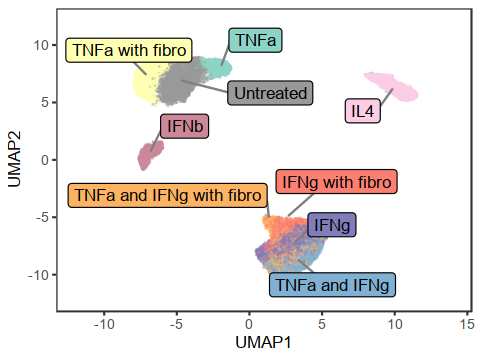

In [275]:
meta_qc$res_0.60_stim <- as.character(meta_qc$res_0.60)

cluster_center <- meta_qc %>%
                  group_by(res_0.60_stim) %>%
                  summarise_at(vars(harmonized_UMAP1, harmonized_UMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)
cluster_center$res_0.60_stim <- as.character(cluster_center$res_0.60_stim)
cluster_center

options(repr.plot.height = 3, repr.plot.width = 4)
ggplot(meta_qc,
       aes(x = harmonized_UMAP1, y = harmonized_UMAP2, fill= res_0.60_stim)
      ) +
  geom_point(size = 0.5, stroke = 0.0001, shape = 21, alpha = 0.5) +
  geom_label_repel(
    data = cluster_center,
    aes(label = res_0.60_stim),
#     fontface = 'bold', 
    size = 3.5, 
    box.padding = unit(0.4, "lines"),
    point.padding = unit(0.2, "lines"),
    segment.color = 'grey50'
  ) +
  scale_fill_manual(values = meta_colors$cluster, name = "") +
  scale_x_continuous(limits = c(-12, 14)) +
  scale_y_continuous(limits = c(-12, 12)) +
  labs(
      x = "UMAP1",
      y = "UMAP2"
      ) +
  theme_bw(base_size = 10) +
  theme(
    legend.position = "none",
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=22, face = "italic")
  )
ggsave(file = paste("blood_new", ".png", sep = ""), width = 4, height = 3, dpi = 500)

## Find marker genes

In [160]:
library(presto)
cluster_marker <- wilcoxauc(exprs_norm_new, meta_qc$res_0.60_stim)

In [236]:
x <- cluster_marker %>%
  group_by(group) %>%
  top_n(10, wt = logFC) 
# x


In [247]:
## Heatmap of marker genes
gene_plot <- unique(x$feature)

exp_heat <- exprs_norm_new[gene_plot_final,]
all(colnames(exp_heat) == meta_qc_new$cell)
exp_heat <- t(exp_heat)
exp_heat <- as.data.frame(exp_heat)
all(rownames(exp_heat) == meta_qc_new$cell)
exp_heat$res_0.60_stim <- as.character(meta_qc_new$res_0.60_stim)
dim(exp_heat)

exp_ave <- aggregate(exp_heat[, 1:(ncol(exp_heat)-1)], list(exp_heat$res_0.60_stim), mean)
colnames(exp_ave)[1] <- "res_0.60_stim"
exp_ave <- as.data.frame(t(exp_ave))
colnames(exp_ave) <- as.character(t(exp_ave[1,]))
exp_ave <- exp_ave[-1,]
row_names <- rownames(exp_ave)

exp_ave <- mutate_all(exp_ave, function(x) as.numeric(as.character(x)))
rownames(exp_ave) <- row_names
class(exp_ave[1,1])         

[1] TRUE

[1] TRUE

[1] 24451    45

[1] "numeric"

In [248]:
exp_ave <- as.matrix(exp_ave)
mat_breaks <- seq(min(exp_ave), max(exp_ave), length.out = 10)
quantile_breaks <- function(xs, n = 10) {
  breaks <- quantile(xs, probs = seq(0, 1, length.out = n))
  breaks[!duplicated(breaks)]
}
mat_breaks <- quantile_breaks(exp_ave, n = 10)

# annotation_col <- meta_all[,c("res_0.60_anno", "diagnosis")] 
# rownames(annotation_col) <- meta_all$cell

# d <- d[,order(annotation_col$res_0.60_anno)]
scale_rows <- function(x) t(scale(t(x)))
exp_ave_scale <- scale_rows(exp_ave) # Z-score
exp_ave_scale[exp_ave_scale > 2] <- 2
exp_ave_scale[exp_ave_scale < -2] <- -2

In [174]:
# Overwrite default draw_colnames in the pheatmap package.
# Thanks to Josh O'Brien at http://stackoverflow.com/questions/15505607
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)

png 
  2

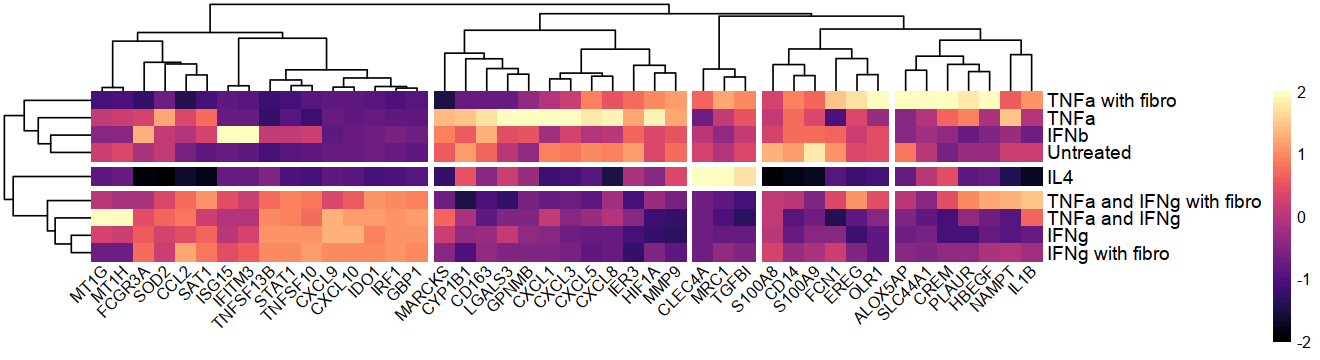

In [256]:
options(repr.plot.width = 11, repr.plot.height = 3)
x <- pheatmap(
  mat = t(exp_ave_scale),
  border_color = NA,
#   breaks  = mat_breaks,
  color  = magma(50),
  show_rownames = TRUE,
  show_colnames = TRUE,
  cluster_rows = TRUE,
  cluster_cols = TRUE,
  cutree_rows = 3,
  cutree_cols = 5,
#   annotation_col = annotation_col,
#   annotation_colors = meta_colors,
  fontsize = 9,
  fontsize_row = 11
#   scale = "none"
)


save_pheatmap_pdf <- function(x, filename, width=11, height=3) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

save_pheatmap_pdf(x, "heatmap_phenotype.pdf")

In [5]:
# meta_qc <- readRDS("qc_meta_all_cluster_trajectory_nGene1200_MT0.1_umap_max.ab.UMIs_0.90_ab.rat_0.10_cell_use_correctlabel_2020-05-11.rds")

In [60]:
# exprs_norm <- readRDS("qc_mRNA_exprs_norm_nGene1200_MT0.1_umap_max.ab.UMIs_0.90_ab.rat_0.10_cell_use_2020-04-15.rds")
# all(colnames(exprs_norm) == meta_qc$cell)

[1] TRUE

# Violin plot

[1] TRUE TRUE TRUE TRUE TRUE

Warning message:
“Ignoring unknown parameters: shape, stroke, grouponX”Warning message:
“Ignoring unknown parameters: shape, stroke, grouponX”Warning message:
“Ignoring unknown parameters: shape, stroke, grouponX”Warning message:
“Ignoring unknown parameters: shape, stroke, grouponX”Warning message:
“Ignoring unknown parameters: shape, stroke, grouponX”

null device 
          1

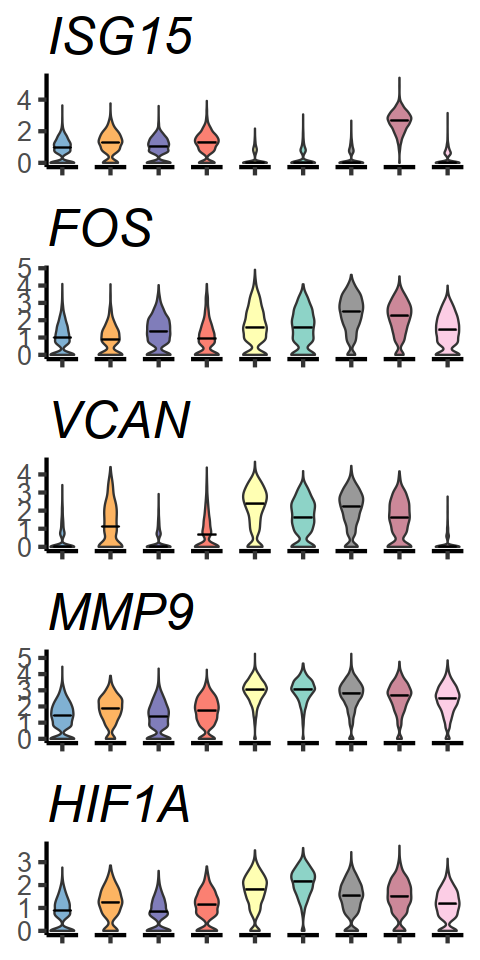

In [214]:
library(ggbeeswarm)


myplots <- list()
plot_gene <- c(
#                  "STAT1", "FCGR1A", "CXCL9", "CXCL10", "FCN1"
#                "IL1B", "CD86", "HBEGF", "PLAUR", "CXCL5"
               "ISG15",  "FOS", "VCAN", "MMP9", "HIF1A" 
#                "CCL23","ALOX15",  "MRC1", "CCL23", "LIPA" # "GPNMB", "CXCL1" # ""
              )
plot_gene %in% rownames(exprs_norm)

options(repr.plot.height = 8, repr.plot.width = 4)
for (i in 1:length(plot_gene)) {
  gene <- plot_gene[i]
  meta_qc$gene <- as.numeric(exprs_norm[which(rownames(exprs_norm) == gene),])

  meta_qc$res_0.60_stim <- factor(meta_qc$res_0.60_stim, 
                                levels = c('TNFa and IFNg', 'TNFa and IFNg with fibro', 'IFNg', 'IFNg with fibro',  
                                 'TNFa with fibro', 'TNFa','Untreated', 'IFNb', 'IL4')
                                 )

    
  ind <- paste("p", i, sep = "")
  ind <- 
    ggplot(
      data    = meta_qc,
      mapping = aes(x = res_0.60_stim, y = gene, fill = res_0.60_stim)
    ) +
    geom_violin(
      shape = 21, stroke = 0.01, size = 0.5, grouponX= TRUE
    ) +
    stat_summary(
       fun.y = median, fun.ymin = median, fun.ymax = median,
       geom = "crossbar", width = 0.7, size = 0.2
    ) +
    scale_fill_manual("", values = meta_colors$cluster) +
    facet_grid( ~ res_0.60_stim, scales = "free", space = "free_x") + 
    guides(
      fill = FALSE,
      alpha = "none"
    ) +
    labs(
      x = NULL,
      y = NULL,
      title = gene
    ) +
    theme_classic(base_size = 20) +
    theme(
      plot.title = element_text(color="black", size=30, face = "italic"), # face="bold.italic"
      strip.background = element_blank(), strip.text = element_blank(),
      panel.grid = element_blank(),
      axis.text.x = element_blank()
#       axis.text.x=element_text(angle=45, hjust=1)
    ) 
  myplots[[i]] <- ind
}


all <- do.call("grid.arrange", c(myplots, ncol = 1))
ggsave(file = paste("blood_violin_3", ".pdf", sep = ""), all, width = 4, height = 8, dpi = 300)
dev.off()

In [53]:
table(meta_qc$sample)


sample_1 sample_2 sample_3 sample_4 
    4622     3027     8775     9399 

In [57]:
dim(meta_qc)

[1] 25823    41